# 全卷积网络
:label:`sec_fcn`

如 :numref:`sec_semantic_segmentation` 中所介绍的那样，语义分割能对图像中的每个像素分类。
全卷积网络 (fully convolutional network，FCN) 采用卷积神经网络实现了从图像像素到像素类别的变换 :cite:`Long.Shelhamer.Darrell.2015`。
与我们之前在图像分类或目标检测部分介绍的卷积神经网络不同，全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸：这是通过 :numref:`sec_transposed_conv` 中引入的*转置卷积*（transposed convolution）层实现的。
因此，输出的类别预测与输入图像在像素级别上具有一一对应关系：给定空间维上的位置，通道维的输出即该位置对应像素的类别预测。


In [1]:
%matplotlib inline
from mxnet import gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()


## 构造模型

下面我们了解一下全卷积网络模型最基本的设计。
如 :numref:`fig_fcn` 所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过 $1\times 1$ 卷积层将通道数变换为类别个数，最后在 :numref:`sec_transposed_conv` 中通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
因此，模型输出与输入图像的高和宽相同，且最终输出的通道包含了该空间位置像素的类别预测。 

![全卷积网络](../img/fcn.svg)
:label:`fig_fcn`

下面，我们[**使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征**]，并将该网络实例记为`pretrained_net`。
该模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。


In [2]:
pretrained_net = gluon.model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-3:], pretrained_net.output

(HybridSequential(
   (0): Activation(relu)
   (1): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (2): Flatten
 ),
 Dense(512 -> 1000, linear))

接下来，我们[**创建一个全卷积网络实例`net`**]。
它复制了Resnet-18中大部分的预训练层，但除去最终的全局平均汇聚层和最接近输出的全连接层。


In [3]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

给定高度和宽度分别为320和480的输入，`net`的前向计算将输入的高和宽减小至原来的$1/32$，即10和15。


In [4]:
X = np.random.uniform(size=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

接下来，我们[**使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。**]
最后，我们需要(**将要素地图的高度和宽度增加32倍**)，从而将其变回输入图像的高和宽。
回想一下 :numref:`sec_padding`中卷积层输出形状的计算方法：
由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为$32$的转置卷积层，并将卷积核的高和宽设为$64$，填充为$16$。
我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。


In [5]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(
            num_classes, kernel_size=64, padding=16, strides=32))

## [**初始化转置卷积层**]

在图像处理中，我们有时需要将图像放大，即*上采样*(upsampling)。
*双线性插值*（bilinear interpolation）
是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。
首先，将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。
例如，根据输入与输出的尺寸之比来映射。
请注意，映射后的$x′$和$y′$是实数。
然后，在输入图像上找到离坐标$(x',y')$最近的4个像素。
最后，输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下`bilinear_kernel`函数构造。
限于篇幅，我们只给出`bilinear_kernel`函数的实现，不讨论算法的原理。


In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1),
          np.arange(kernel_size).reshape(1, -1))
    filt = (1 - np.abs(og[0] - center) / factor) * \
           (1 - np.abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight)

让我们用[**双线性插值的上采样实验**]它由转置卷积层实现。
我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化。


In [7]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

读取图像`X`，将上采样的结果记作`Y`。为了打印图像，我们需要调整通道维的位置。


In [8]:
img = image.imread('../img/catdog.jpg')
X = np.expand_dims(img.astype('float32').transpose(2, 0, 1), axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose(1, 2, 0)

可以看到，转置卷积层将图像的高和宽分别放大了2倍。
除了坐标刻度不同，双线性插值放大的图像和在 :numref:`sec_bbox`中打印出的原图看上去没什么两样。


input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


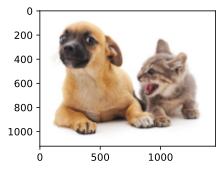

In [9]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

在全卷积网络中，我们[**用双线性插值的上采样初始化转置卷积层。对于$1\times 1$卷积层，我们使用Xavier初始化参数。**]


In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net[-1].initialize(init.Constant(W))
net[-2].initialize(init=init.Xavier())

## [**读取数据集**]

我们用 :numref:`sec_semantic_segmentation` 中介绍的语义分割读取数据集。
指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被$32$整除。


In [11]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


read 1078 examples


## [**训练**]

现在我们可以训练全卷积网络了。
这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以在损失计算中通道维是指定的。
此外，模型基于每个像素的预测类别是否正确来计算准确率。


loss 0.335, train acc 0.890, test acc 0.848
191.6 examples/sec on [gpu(0), gpu(1)]


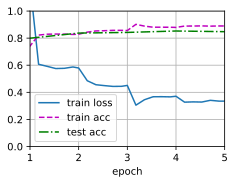

In [12]:
num_epochs, lr, wd, devices = 5, 0.1, 1e-3, d2l.try_all_gpus()
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(devices)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': lr, 'wd': wd})
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## [**预测**]

在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。


In [13]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = np.expand_dims(X.transpose(2, 0, 1), axis=0)
    pred = net(X.as_in_ctx(devices[0])).argmax(axis=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

为了[**可视化预测的类别**]给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。


In [14]:
def label2image(pred):
    colormap = np.array(d2l.VOC_COLORMAP, ctx=devices[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

测试数据集中的图像大小和形状各异。
由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。
为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向计算。
请注意，这些区域的并集需要完整覆盖输入图像。
当一个像素被多个区域所覆盖时，它在不同区域前向计算中转置卷积层输出的平均值可以作为`softmax`运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。
对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。


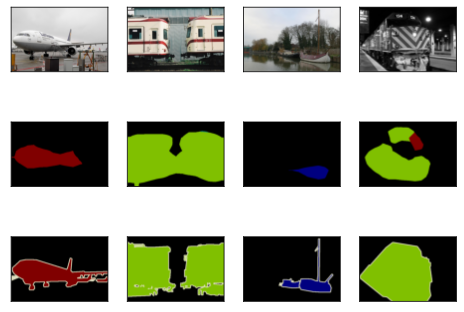

In [15]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## 小结

* 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
* 在全卷积网络中，我们可以将转置卷积层初始化为双线性插值的上采样。

## 练习

1. 如果将转置卷积层改用Xavier随机初始化，结果有什么变化？
1. 调节超参数，能进一步提升模型的精度吗？
1. 预测测试图像中所有像素的类别。
1. 最初的全卷积网络的论文中 :cite:`Long.Shelhamer.Darrell.2015` 还使用了卷积神经网络的某些中间层的输出。试着实现这个想法。


[Discussions](https://discuss.d2l.ai/t/3298)
